In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import math
import statistics
import pickle
import multiprocessing
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
from matplotlib import cm
#import cmocean

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs


In [3]:
from dask.distributed import Client, LocalCluster
if __name__ == "__main__":
    cluster=LocalCluster(host="tcp://127.0.0.1:2419",dashboard_address="127.0.0.1:2429",n_workers=4)
    client = Client(cluster)

In [4]:
def get_pressure_weighted(x):
    dPref = (x.plev.values[0]-x.plev.values[-1])  #(p-ps)
    integral = []
    for i in range(len(x.plev)): #Integral of variable from P to Ps calculated as area between each pressure variable trapezoid then summed
        if i+1 < len(x.plev):
            area=((x.loc[dict(plev=x.plev.values[i])] + x.loc[dict(plev=x.plev.values[i+1])])/2)*(x.plev.values[i]-x.plev.values[i+1])
            integral.append(area)
    pw = (sum(integral))/dPref
    return(pw)

In [5]:
def seasoning(month):
    if (month == 12) | (month == 1) | (month == 2):
        return(1)
    if (month == 3) | (month == 4) | (month == 5):
        return(2)
    if (month == 6) | (month == 7) | (month == 8):
        return(3)
    if (month == 9) | (month == 10) | (month == 11):
        return(4)

In [6]:
def low_pass_weights(window, cutoff):
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [7]:
def getrange(numbers):
    return max(numbers) - min(numbers)

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
def get_files():
    models = glob.glob("/terra/data/cmip5/global/historical/*")
    avail={}
    for model in models:
        ua = glob.glob(str(model)+"/r1i1p1/day/native/ua_*")
        try:
            test = ua[0]
            avail[model.split('/')[-1]] = ua
        except:
             pass
    return avail

In [10]:
def jettrack(d):
    infer = np.linspace(-75, 15, 501)
    out = []
    size = len(d.lat)-1
    a = d.load()
    b = a.where(a==a.max(dim='lat')) #find max zonal mean/set rest to Nan
    for i in range(len(a.values)): #each day
        fwhm=[]
        for j in range(len(a.values[i])): #each lat
            if math.isnan(b.values[i][j])==False: #if a maximum is found
                if j==0 or j==size:
                    lat = a.lat.values[j]
                    ua = b.values[i][j]
                    break
                else:
                    p = np.poly1d(np.polyfit(b.lat.values[j-1:j+2],a.values[i][j-1:j+2],2)) #fit quadratic to interpolate
                    lat = pd.DataFrame(p(infer),index=infer).idxmax().values[0]
                    ua = pd.DataFrame(p(infer),index=infer).max().values[0]
                    break
        for k in range(len(b.lat.values)): #check against each lat to find width
            if a.values[i][k] >= ua/2:
                fwhm.append(k) #full width half mean
        if len(fwhm) >= 2: #some days no latitudes other than maximum meet fwhm criteria
            if fwhm[0]==0: #if bottom is maximum latitude else interpolate with linear model
                bottom = b.lat.values[fwhm[0]]
            else:
                wb = np.poly1d(np.polyfit(b.lat.values[fwhm[0]-1:fwhm[0]+2],a.values[i][fwhm[0]-1:fwhm[0]+2],1))
                inf = infer
                bottom = inf[find_nearest(wb(inf),ua/2)]
            if fwhm[-1]==size: #if top is minimum latitude else interpolate with linear model
                top = b.lat.values[fwhm[-1]]
            else:
                wt = np.poly1d(np.polyfit(b.lat.values[fwhm[-1]-1:fwhm[-1]+2],a.values[i][fwhm[-1]-1:fwhm[-1]+2],1))
                inf = infer
                top = inf[find_nearest(wt(inf),ua/2)]
            width = top - bottom
        else:
            width = np.nan
        out.append([a[i].time.values,lat,ua,width,top,bottom]) #append to list
        a.close()
    df = pd.DataFrame(np.array(out),columns=['time', 'lat', 'ua','width','top','bottom'])
    return df

In [11]:
files = get_files()

In [13]:
d = xr.open_mfdataset(files['ACCESS1-0'])
d = xr.concat([d.sel(lon = slice(0,30)),d.sel(lon = slice(320,360))],dim='lon')
d.coords['lon'] = (d.coords['lon'] + 180) % 360 - 180
d = d.sel(lat = slice(-75,-15))
d = d.sortby(d.lat)
d = d.sortby(d.lon)
d = d.sel(time=slice('2000', '2000')).load()
dalllevel = d.loc[dict(plev=d.plev.values[1:-2])]
dalllevel = get_pressure_weighted(dalllevel.ua)
dalllevel = dalllevel[20:-21]

In [14]:
d = d.sel(plev=[85000,70000],method='nearest')
d = get_pressure_weighted(d.ua)
dnofilter = d  #!
dnofilter = dnofilter[20:-21]

In [15]:
wgts = low_pass_weights(41, 1/10)
weight = xr.DataArray(list(wgts), dims=['window'])
d10day = d.rolling(time=41, center=True).construct('window').dot(weight)
d10day = d10day[20:-21]

In [16]:
i = 10
vmin=-20
vmax=20

In [17]:
dmean = d10day.mean(dim='lon')
values = jettrack(dmean)

<ipython-input-19-3e49164a52ea>:14: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_visible(False)
<ipython-input-19-3e49164a52ea>:19: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax2.outline_patch.set_visible(False)
<ipython-input-19-3e49164a52ea>:29: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax3.outline_patch.set_visible(False)


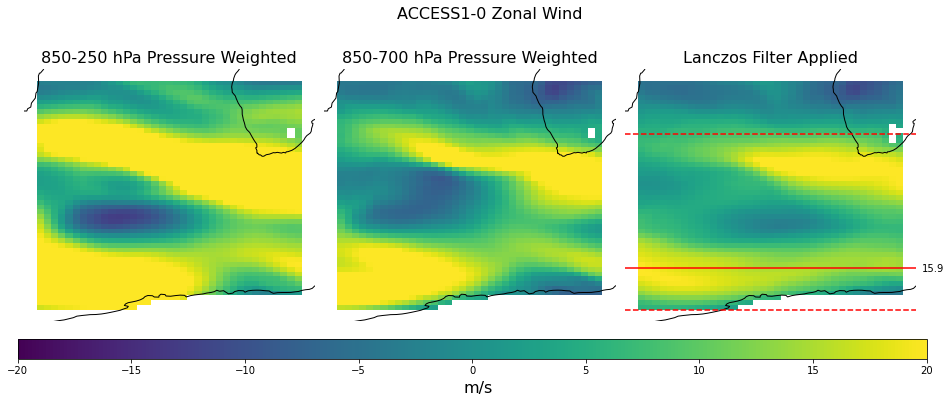

In [19]:
for i in [103]: #range(len(dalllevel.time)):
    fig = plt.figure(figsize=(16, 9))
    plt.gca().set_visible(False)
    gs = gridspec.GridSpec(nrows=9,
                           ncols=9,
                           figure=fig,
                           width_ratios= [1, 1, 1, 1, 1, 1, 1, 1, 1],
                           height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1],
                           wspace=0.1,
                           hspace=0.1)
    ax1 = fig.add_subplot(gs[1:8,0:3], projection=ccrs.PlateCarree())
    ax1.coastlines()
    z = dalllevel.sel(time=dalllevel.time[i].values).plot(ax=ax1,vmin=vmin, vmax=vmax, add_colorbar=False)#,cmap=cmap)
    ax1.outline_patch.set_visible(False)
    plt.title('850-250 hPa Pressure Weighted', fontsize=16, ha='center')
    ax2 = fig.add_subplot(gs[1:8,3:6], projection=ccrs.PlateCarree())
    ax2.coastlines()
    dnofilter.sel(time=dnofilter.time[i].values).plot(ax=ax2,vmin=vmin, vmax=vmax,add_colorbar=False)#,cmap=cmap)
    ax2.outline_patch.set_visible(False)
    plt.title('850-700 hPa Pressure Weighted', fontsize=16, ha='center')
    plt.text(0.5, 1.08,'ACCESS1-0 Zonal Wind', fontsize=16, ha='center')
    ax3 = fig.add_subplot(gs[1:8,6:9], projection=ccrs.PlateCarree())
    ax3.coastlines()
    d10day.sel(time=d10day.time[i].values).plot(ax=ax3,vmin=vmin, vmax=vmax,add_colorbar=False)#,cmap=cmap)
    plt.axhline(y=values.iloc[i].lat,color='r', linestyle='-')
    plt.text(35, values.iloc[i].lat-1, str(round(values.iloc[i].ua,1)))
    plt.axhline(y=values.iloc[i].top,color='r', linestyle='dashed')
    plt.axhline(y=values.iloc[i].bottom,color='r', linestyle='dashed')
    ax3.outline_patch.set_visible(False)
    plt.title('Lanczos Filter Applied', fontsize=16, ha='center')
    ax4 = fig.add_subplot(gs[8:9,0:9])
    img = dalllevel.sel(time=dalllevel.time[i].values).plot(ax=ax4,vmin=vmin, vmax=vmax,add_colorbar=False)#,cmap=cmap)
    ax4.set_visible(False)
    cax = plt.axes([0.12, 0.25, 0.789, 0.03])
    plt.colorbar(z,orientation= 'horizontal', cax=cax)
    plt.text(0.26, -90,'m/s', fontsize=16, ha='center')
    plt.savefig('../JET_OUT/demonstration_1D/'+str(i)+'_togif.png')
    plt.show()